<a href="https://colab.research.google.com/github/andrew-okello/pneumonia_detection/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd 
import random as rn

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob
from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)
# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [ ]:
data_path ='../input/chest-xray-pneumonia//chest_xray/chest_xray/'
data_path

train_path = data_path + 'train\\'
test_path = data_path + 'test\\'
val_path = data_path + 'val\\'

In [ ]:
img_size = 200

In [ ]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [ ]:
train = read_data([train_path])
test = read_data([val_path, test_path])

FileNotFoundError: ignored

In [ ]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [ ]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [ ]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2       NORMAL
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

C:\Users\ROXTON\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ROXTON\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


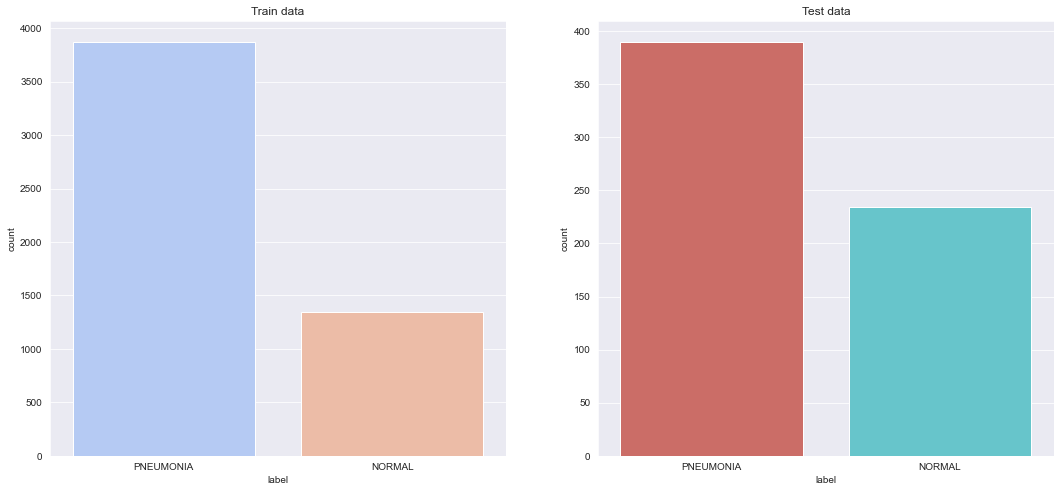

In [ ]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

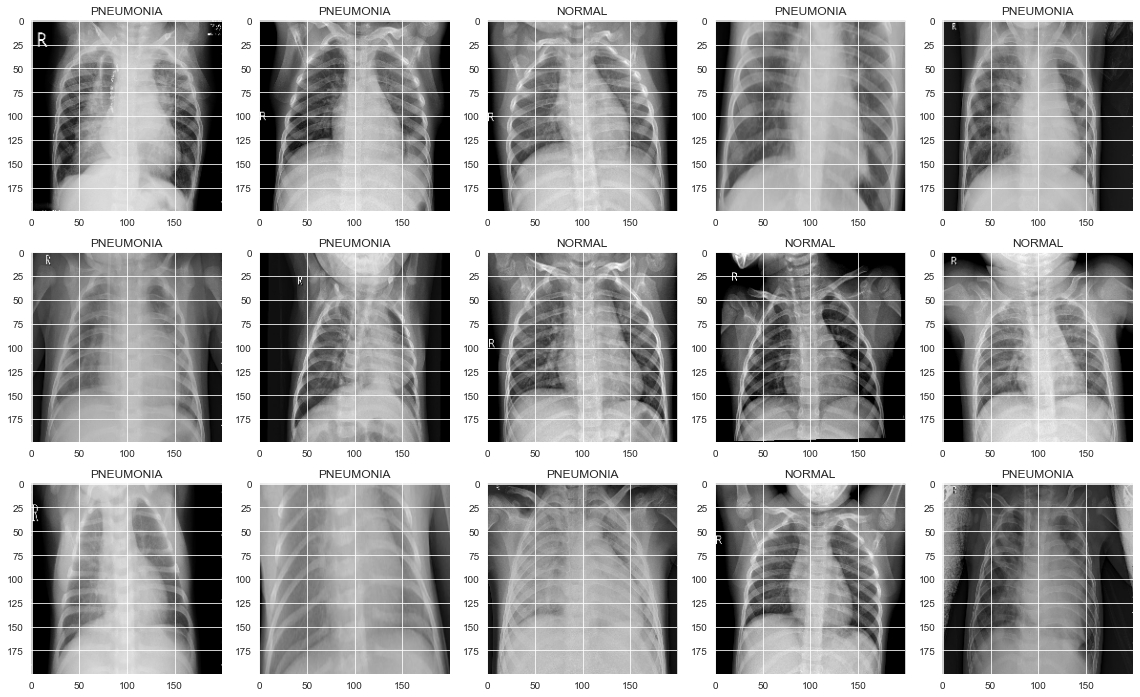

In [ ]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

In [ ]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [ ]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [ ]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [ ]:
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

In [ ]:
X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)


In [ ]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [ ]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('C:\\Users\\ROXTON\\Desktop\\chest_xray\\model.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

# First Model

In [ ]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [ ]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


# fit model

In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
82/82 - 99s - loss: 0.4079 - accuracy: 0.8102 - val_loss: 0.5321 - val_accuracy: 0.7292
Epoch 2/40
82/82 - 79s - loss: 0.2031 - accuracy: 0.9231 - val_loss: 0.4260 - val_accuracy: 0.7901
Epoch 3/40
82/82 - 82s - loss: 0.1503 - accuracy: 0.9446 - val_loss: 0.5347 - val_accuracy: 0.7708
Epoch 4/40
82/82 - 81s - loss: 0.1358 - accuracy: 0.9500 - val_loss: 0.4869 - val_accuracy: 0.7933
Epoch 5/40
82/82 - 80s - loss: 0.1233 - accuracy: 0.9548 - val_loss: 0.6659 - val_accuracy: 0.7628
Epoch 6/40
82/82 - 78s - loss: 0.1262 - accuracy: 0.9538 - val_loss: 0.6530 - val_accuracy: 0.7756
Epoch 7/40
82/82 - 76s - loss: 0.1131 - accuracy: 0.9582 - val_loss: 1.3802 - val_accuracy: 0.6939
Epoch 8/40
82/82 - 75s - loss: 0.1244 - accuracy: 0.9530 - val_loss: 0.5753 - val_accuracy: 0.7965
Epoch 9/40
82/82 - 78s - loss: 0.1055 - accuracy: 0.9617 - val_loss: 0.7159 - val_accuracy: 0.7660
Epoch 10/40
82/82 - 76s - loss: 0.1067 - accuracy: 0.9594 - val_loss: 0.8313 - val_accuracy: 0.7532
Epoch 11/

In [ ]:
model = load_model('C:\\Users\\ROXTON\\Desktop\\chest_xray\\model.hdf5')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 100.77309608459473%
Test accuracy: 73.71794581413269%
MLP Error: 26.28%


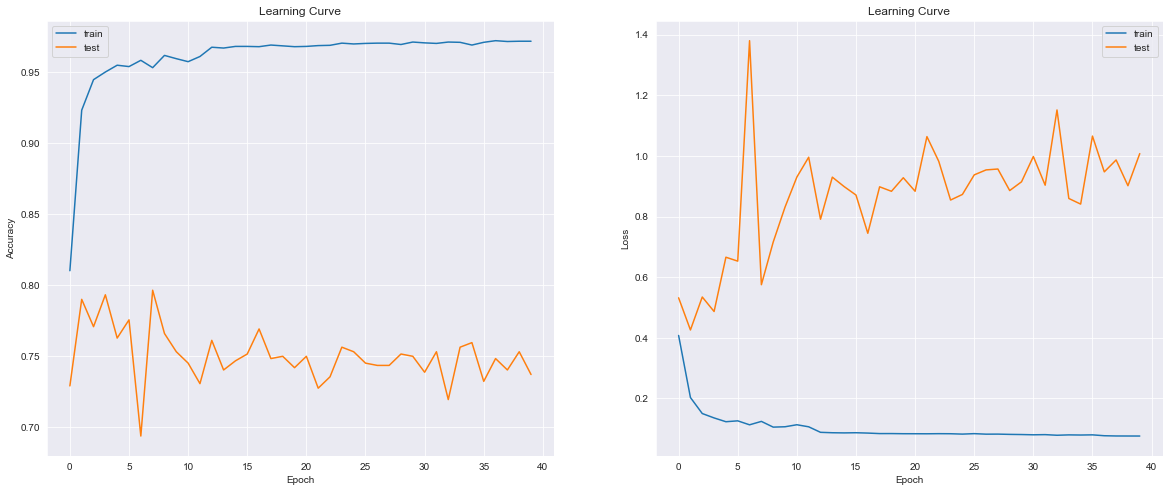

In [ ]:
draw_learning_curve(learning_history)

# Data preparing for CNN

We need to rehaspe data again

In [ ]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

Grayscale conversion, normalization and table reshaping function for CNN

In [ ]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [ ]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

MemoryError: Unable to allocate 4.66 GiB for an array with shape (5216, 200, 200, 3) and data type float64